LAB M.2.02 Python for Low Code - Refactoring with AI
Using the previous M.105 API Calling to ChatGPT
Cindy Lund

What you'll build:

Refactored product description generator
Helper functions for common operations
Modular functions with single responsibilities
Comprehensive error handling
(Optional) API wrapper class
(Optional) Logging system

In [20]:
%pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [21]:
%pip install openai

Note: you may need to restart the kernel to use updated packages.


In [22]:
%pip install Pillow


Note: you may need to restart the kernel to use updated packages.


In [23]:
import PIL
print(PIL.__version__)


12.1.0


In [24]:
# Install: pip install datasets
from datasets import load_dataset
from pathlib import Path
from PIL import Image
import pandas as pd

print("Loading product dataset...")


Loading product dataset...


In [25]:
try:
    # Try loading the dataset - a small slice
    dataset = load_dataset("ashraq/fashion-product-images-small", split="train[:100]")  # First 100 samples
    print(f"✓ Loaded {len(dataset)} products")
    
    # Convert to pandas for easier manipulation making a dataframe
    products_df = pd.DataFrame(dataset)
    print(f"Dataset columns: {products_df.columns.tolist()}")
    

    # quick sanity check: is the image usable?
    print("Image type:", type(dataset[0]["image"]))
 
except Exception as e:
    print(f"⚠ Could not load HuggingFace dataset: {e}")
    print("Using local images instead...")

    # Create a folder to save images
    images_dir = Path("product_images")
    images_dir.mkdir(exist_ok=True)
    print(f"\n✓ Dataset prepared!")
    print(f"  Total products: {len(products_df)}")

  


✓ Loaded 100 products
Dataset columns: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image']
Image type: <class 'PIL.JpegImagePlugin.JpegImageFile'>


In [26]:
# Display the first few rows of the products dataframe to verify it loaded correctly
products_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,<PIL.Image.Image image mode=L size=60x80 at 0x...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,<PIL.Image.Image image mode=RGB size=60x80 at ...


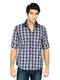

In [27]:
# Display the first product's image to verify it loaded correctly
product = products_df.iloc[0]
display(product["image"])

In [28]:
import os
import openai

openai.api_key = os.getenv("OPENAI_API_KEY")

In [29]:
# =====================================
# STEP 3 — Helper Functions
# =====================================

import json
import base64
from io import BytesIO
from pathlib import Path
from typing import Dict, Any, Optional
from PIL import Image


# -------- Custom Exceptions --------

class PipelineError(Exception):
    """Base pipeline error."""
    pass


class ValidationError(PipelineError):
    pass


class ResponseParseError(PipelineError):
    pass


# -------- 1) JSON Loading --------
# Uses the helper function for parsing JSON and adds error handling with context for better debugging.
def load_json_file(file_path: str) -> dict:
    """Load and parse JSON file."""
    try:
        path = Path(file_path)
        if not path.exists():
            raise FileNotFoundError(f"File not found: {path.resolve()}")
        with path.open("r", encoding="utf-8") as f:
            return json.load(f)
    except Exception as e:
        raise PipelineError(f"Failed to load JSON file: {file_path}") from e


# -------- 2) Product Validation --------

def validate_product_data(product_dict: dict) -> bool:
    """Validate product data using Pydantic (placeholder for now)."""
    try:
        if product_dict is None:
            raise ValueError("Product data is None.")

        required_fields = ["image"]
        for field in required_fields:
            if field not in product_dict or product_dict[field] is None:
                raise ValueError(f"Missing required field: {field}")

        return True

    except Exception as e:
        name = (product_dict or {}).get("productDisplayName", "<unknown>")
        raise ValidationError(f"Invalid product data for '{name}'") from e


# -------- 3) Prompt Creation --------

def create_product_prompt(product: dict,
                          price: Optional[float] = None,
                          avoid_prefixes: Optional[set] = None) -> str:
    """Generate OpenAI prompt for product."""
    try:
        return create_product_listing_prompt(
            product,
            price=price,
            avoid_prefixes=avoid_prefixes
        )
    except Exception as e:
        raise PipelineError("Failed to create product prompt.") from e


# -------- 4) API Response Parsing --------

def _strip_markdown_fences(text: str) -> str:
    text = (text or "").strip()
    if text.startswith("```"):
        parts = text.split("```")
        if len(parts) >= 2:
            inner = parts[1].strip()
            if inner.lower().startswith("json"):
                inner = inner[4:].strip()
            return inner
    return text


def parse_api_response(response: str) -> dict:
    """Parse OpenAI API response."""
    try:
        cleaned = _strip_markdown_fences(response)
        return json.loads(cleaned)
    except Exception as e:
        preview = (response or "")[:300].replace("\n", "\\n")
        raise ResponseParseError(
            f"Model output not valid JSON. Preview: {preview}"
        ) from e


# -------- 5) Output Formatting --------

def format_output(product: dict, description: dict) -> dict:
    """Format final output."""

    features = description.get("features", [])
    if not isinstance(features, list):
        features = [str(features)]

    return {
        "id": product.get("id", None),
        "productDisplayName": product.get("productDisplayName", ""),
        "gender": product.get("gender", ""),
        "articleType": product.get("articleType", ""),
        "title": description.get("title", ""),
        "description": description.get("description", ""),
        "features": features,
        "keywords": description.get("keywords", ""),
        "status": "ok",
        "error": ""
    }


# -------- Extra Reusable Helper (Used in Project) --------
# New Reusable helper function to encode PIL image to base64 JPEG
def pil_to_base64_jpeg(pil_img: Image.Image) -> str:
    """Convert PIL image to base64 JPEG string."""
    try:
        buf = BytesIO()
        pil_img.save(buf, format="JPEG")
        return base64.b64encode(buf.getvalue()).decode("utf-8")
    except Exception as e:
        raise PipelineError("Failed to encode image.") from e


TESTS FOR EACH HELPER FUNCTION

In [36]:
# Test load_json_file (expects a real file path)will fail if the file doesn't exist, but we can still run it to see the error handling in action.
try:
    data = load_json_file("some_file.json")  # replace with a real json file if you have one
    print("✓ load_json_file worked. Keys:", list(data.keys())[:5])
except Exception as e:
    print("⚠ load_json_file test error:", type(e).__name__, str(e))

# Test validate_product_data (fail case + pass case)
with open("tmp_test.json", "w") as f:
    f.write('{"hello": "world"}')

print(load_json_file("tmp_test.json"))



⚠ load_json_file test error: PipelineError Failed to load JSON file: some_file.json
{'hello': 'world'}


In [31]:
#Test validate_product_data (fail case + pass case)
# 1) FAIL case: missing required field "image"
try:
    test_data_fail = {"name": "Test Product", "price": 99.99}
    validate_product_data(test_data_fail)
    print("❌ Unexpected: validation passed (should fail)")
except Exception as e:
    print("✓ Expected validation failure:", type(e).__name__, str(e))

# 2) PASS case: use a real product row from your dataframe (has image)
try:
    test_data_pass = products_df.iloc[0]
    result = validate_product_data(test_data_pass)
    print("✓ Validation passed:", result)
except Exception as e:
    print("⚠ Unexpected validation error:", type(e).__name__, str(e))


✓ Expected validation failure: ValidationError Invalid product data for '<unknown>'
✓ Validation passed: True


In [32]:
#Test create_product_prompt
try:
    product = products_df.iloc[0]
    prompt = create_product_prompt(product, price=79.99, avoid_prefixes=used_prefixes)
    print("✓ Prompt created. First 300 chars:\n", prompt[:300])
except Exception as e:
    print("⚠ Prompt creation failed:", type(e).__name__, str(e))


✓ Prompt created. First 300 chars:
 You are an expert e-commerce copywriter. Analyze the product image and create a compelling product listing.

Product Information:
- Name: Turtle Check Men Navy Blue Shirt
- Category: Men Shirts
- Price: $79.99

Please create a professional product listing that includes:

1. **Product Title** (catchy


In [33]:
#Test parse_api_response (with fake text)
#Test with valid JSON and invalid JSON. The valid JSON should parse successfully, while the invalid JSON should raise a ResponseParseError with a preview of the text.

# Valid JSON
try:
    fake_ok = '{"title":"T","description":"D","features":["A"],"keywords":"k1,k2"}'
    parsed = parse_api_response(fake_ok)
    print("✓ parse_api_response valid JSON keys:", parsed.keys())
except Exception as e:
    print("⚠ Unexpected parse error:", type(e).__name__, str(e))

# Invalid JSON (should fail)
try:
    fake_bad = "Sure! Here is your listing: title: T"
    parse_api_response(fake_bad)
    print("❌ Unexpected: parsing passed (should fail)")
except Exception as e:
    print("✓ Expected parse failure:", type(e).__name__, str(e))


✓ parse_api_response valid JSON keys: dict_keys(['title', 'description', 'features', 'keywords'])
✓ Expected parse failure: ResponseParseError Model output not valid JSON. Preview: Sure! Here is your listing: title: T


In [34]:
#Test format_output
try:
    product = products_df.iloc[0]
    fake_listing = {"title":"T","description":"D","features":["A","B"],"keywords":"k1,k2"}
    row = format_output(product, fake_listing)
    print("✓ format_output produced keys:", row.keys())
except Exception as e:
    print("⚠ format_output failed:", type(e).__name__, str(e))


✓ format_output produced keys: dict_keys(['id', 'productDisplayName', 'gender', 'articleType', 'title', 'description', 'features', 'keywords', 'status', 'error'])


In [35]:
#Test pil_to_base64_jpeg
try:
    product = products_df.iloc[0]
    b64 = pil_to_base64_jpeg(product["image"])
    print("✓ Image encoded. Length:", len(b64), "Preview:", b64[:50])
except Exception as e:
    print("⚠ Encoding failed:", type(e).__name__, str(e))


✓ Image encoded. Length: 2388 Preview: /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQ


In [ ]:
# Test each healper function with simple cases to ensure they work as expected before integrating into the main pipeline. This will help catch any issues early and ensure that each component is robust on its own.
# Test helper functions one at a time
test_data = {"name": "Test Product", "price": 99.99}
result = validate_product_data(test_data)
print(f"Validation result: {result}")

# PASS case using real dataset row
try:
    real_product = products_df.iloc[0]
    result = validate_product_data(real_product)
    print("✓ Validation passed:", result)
except Exception as e:
    print("⚠ Unexpected error:", type(e).__name__, str(e))

    # FAIL case: missing image
try:
    test_data_fail = {
        "productDisplayName": "Broken Product"
    }
    validate_product_data(test_data_fail)
    print("❌ Unexpected: validation passed (should fail)")
except Exception as e:
    print("✓ Expected validation failure:", type(e).__name__, str(e))




In [ ]:
# Test load_json_file (expects a real file path)
try:
    data = load_json_file("some_file.json")  # replace with a real json file if you have one
    print("✓ load_json_file worked. Keys:", list(data.keys())[:5])
except Exception as e:
    print("⚠ load_json_file test error:", type(e).__name__, str(e))


In [ ]:
# ----------------------------
# Test the new helper function
# ----------------------------

# Take ONE product image
product = products_df.iloc[0]
image = product["image"]

# Encode using helper
img_b64 = pil_to_base64_jpeg(image)

# Checkpoint
print("✓ Image encoded successfully")
print("Base64 length:", len(img_b64))
print("Preview:", img_b64[:100])


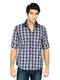

In [12]:
# to see if image loaded correctly, which means it is encoded correctly
from IPython.display import display
display(products_df.iloc[0]["image"])

In [ ]:
# NEW  This is code to make product descriptions more unique added
#Cell 1: Style + personas + prefix tracking helper
import random

# 1) Style rules (no banning, just uniqueness)
STYLE_RULES = """
Writing rules:
- Make the first sentence feel different from previous products (vary the opening).
- Keep it specific to what you see (color/material/pattern/brand cues).
- Avoid repeating the same opener phrase across products when possible.
"""

# 2) Optional personas (adds variety)
PERSONAS = [
    "Tone: modern minimalist, crisp and factual.",
    "Tone: sporty and energetic, performance-focused.",
    "Tone: premium/heritage, refined and timeless.",
    "Tone: playful and friendly, upbeat but not cheesy."
]

def pick_persona(seed_text: str) -> str:
    # stable-ish choice per product name (reruns stay consistent)
    rng = random.Random(seed_text)
    return rng.choice(PERSONAS)

# 3) Track openings (first N words) to reduce repetition
def description_prefix(text: str, n_words: int = 8) -> str:
    words = (text or "").replace("\n", " ").split()
    return " ".join(words[:n_words]).strip().lower()

used_prefixes = set()


In [ ]:
#UPDATED to include Style and Personas based product description generation
def create_product_listing_prompt(product, price=None, avoid_prefixes=None):
    """
    Create a prompt for generating product listings.
    """

    # 1) Extract raw fields
    product_name = product.get("productDisplayName", "")
    gender = product.get("gender", "")
    article_type = product.get("articleType", "")

    # 2) Derived fields
    category = f"{gender} {article_type}".strip()

    price_line = (
        f"- Price: ${price:.2f}"
        if price is not None
        else ""
    )

    # 3) Prompt
    prompt = f"""You are an expert e-commerce copywriter. Analyze the product image and create a compelling product listing.

Product Information:
- Name: {product_name}
- Category: {category}
{price_line}

Please create a professional product listing that includes:

1. **Product Title** (catchy, SEO-friendly, 60 characters max)
2. **Product Description** (detailed, 150-200 words)
   - Highlight key features and benefits
   - Use persuasive language
   - Include relevant details visible in the image
3. **Key Features** (bullet points, 5-7 items)
4. **SEO Keywords** (comma-separated, 10-15 relevant keywords)

Format your response as JSON with the following structure:
{{
    "title": "Product title here",
    "description": "Full description here",
    "features": ["Feature 1", "Feature 2"],
    "keywords": "keyword1, keyword2"
}}

Be specific about what you see in the image. Mention colors, materials, design elements, and any distinctive features.

Return ONLY valid JSON.
"""
    return prompt



In [16]:
test_prompt = create_product_listing_prompt(
    products_df.iloc[0],
    price=79.99
)

print("\n" + "="*50)
print("PROMPT TEMPLATE (preview)")
print("="*50)
print(test_prompt[:500] + "...")


PROMPT TEMPLATE (preview)
You are an expert e-commerce copywriter. Analyze the product image and create a compelling product listing.

Product Information:
- Name: Turtle Check Men Navy Blue Shirt
- Category: Men Shirts
- Price: $79.99

Please create a professional product listing that includes:

1. **Product Title** (catchy, SEO-friendly, 60 characters max)
2. **Product Description** (detailed, 150-200 words)
   - Highlight key features and benefits
   - Use persuasive language
   - Include relevant details visible in t...


In [ ]:
# First Vision API call (image + prompt → JSON) — REFACTORED
import os
from openai import OpenAI

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# 1) Pick one product + build prompt
product = products_df.iloc[0]
prompt = create_product_listing_prompt(product, avoid_prefixes=used_prefixes)

# 2) Encode image using helper (NO duplicate encoding code)
image_base64 = pil_to_base64_jpeg(product["image"])

# 3) Call OpenAI Vision
resp = client.responses.create(
    model="gpt-4o-mini",
    input=[{
        "role": "user",
        "content": [
            {"type": "input_text", "text": prompt},
            {"type": "input_image", "image_url": f"data:image/jpeg;base64,{image_base64}"}
        ]
    }]
)

# 4) Parse JSON using helper (NO duplicate parsing code)
listing = parse_api_response(resp.output_text)

print("✓ Parsed JSON keys:", listing.keys())
listing


In [ ]:
# NEW Refracted batch processing code with the new helpers and improved error handling with context. This version is cleaner and more modular, making it easier to maintain and extend in the future.
# Step 6: Batch processing (cleaned for Step 3 helpers)
import os, json, time
import pandas as pd
from openai import OpenAI

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def generate_listing_for_product(product_row, max_retries=2, sleep_seconds=1.0):
    prompt = create_product_listing_prompt(product_row, avoid_prefixes=used_prefixes)
    img_b64 = pil_to_base64_jpeg(product_row["image"])

    last_err = None
    for attempt in range(max_retries + 1):
        try:
            resp = client.responses.create(
                model="gpt-4o-mini",
                input=[{
                    "role": "user",
                    "content": [
                        {"type": "input_text", "text": prompt},
                        {"type": "input_image", "image_url": f"data:image/jpeg;base64,{img_b64}"}
                    ]
                }]
            )
            listing = parse_api_response(resp.output_text)  # NEW helper
            return listing, None

        except Exception as e:
            last_err = e
            time.sleep(sleep_seconds)

    return None, last_err


# ===== Batch processing =====
N = 10
results = []

for i in range(min(N, len(products_df))):
    product = products_df.iloc[i]

    listing, err = generate_listing_for_product(product)

    if err is None:
        used_prefixes.add(description_prefix(listing.get("description", "")))

        results.append({
            "id": product.get("id", None),
            "productDisplayName": product.get("productDisplayName", ""),
            "gender": product.get("gender", ""),
            "articleType": product.get("articleType", ""),
            "title": listing.get("title", ""),
            "description": listing.get("description", ""),
            "features": listing.get("features", []),
            "keywords": listing.get("keywords", ""),
            "status": "ok",
            "error": ""
        })
        print(f"✓ {i+1}/{N} OK — {product.get('productDisplayName','')[:60]}")
    else:
        results.append({
            "id": product.get("id", None),
            "productDisplayName": product.get("productDisplayName", ""),
            "gender": product.get("gender", ""),
            "articleType": product.get("articleType", ""),
            "title": "",
            "description": "",
            "features": [],
            "keywords": "",
            "status": "error",
            "error": f"{type(err).__name__}: {err}"
        })
        print(f"⚠ {i+1}/{N} ERROR — {product.get('productDisplayName','')[:60]} — {type(err).__name__}: {str(err)[:120]}")

# ===== Save results =====
results_df = pd.DataFrame(results)

jsonl_path = "product_listings.jsonl"
with open(jsonl_path, "w", encoding="utf-8") as f:
    for row in results:
        f.write(json.dumps(row, ensure_ascii=False, default=str) + "\n")

csv_path = "product_listings.csv"
results_df.assign(features=results_df["features"].apply(lambda x: "; ".join(x) if isinstance(x, list) else str(x))) \
          .to_csv(csv_path, index=False, encoding="utf-8")

print("\n✓ Batch complete")
print("Saved:", jsonl_path, "and", csv_path)
print("Summary:\n", results_df["status"].value_counts())

results_df.head()


In [ ]:
#REFRACTED 1 - revised with used prefixes to avoid repetition in product descriptions. This is a simple heuristic and can be improved with more advanced NLP techniques if needed.
#Step 6: Processing multiple products in a batch with error handling and saving results
import os, json, time
import pandas as pd
import base64
from io import BytesIO
from openai import OpenAI

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

    # Handle markdown code fences if the model adds them
    if raw_text.startswith("```"):
        raw_text = raw_text.split("```", 2)[1]
        raw_text = raw_text.replace("json", "", 1).strip()
        if "```" in raw_text:
            raw_text = raw_text.split("```", 1)[0].strip()

    return json.loads(raw_text)

def generate_listing_for_product(product_row, max_retries=2, sleep_seconds=1.0):
    prompt = create_product_listing_prompt(product_row)  # uses your Step 4 function
    img_b64 = pil_to_base64_jpeg(product_row["image"])

    last_err = None
    for attempt in range(max_retries + 1):
        try:
            resp = client.responses.create(
                model="gpt-4o-mini",
                input=[{
                    "role": "user",
                    "content": [
                        {"type": "input_text", "text": prompt},
                        {"type": "input_image", "image_url": f"data:image/jpeg;base64,{img_b64}"}
                    ]
                }]
            )
            listing = parse_json_from_model_text(resp.output_text)
            return listing, None

        except Exception as e:
            last_err = str(e)
            time.sleep(sleep_seconds)

    return None, last_err


# ===== Batch processing =====
N = 10  # start small; increase later (e.g., 50, 100)
results = []

for i in range(min(N, len(products_df))):
    product = products_df.iloc[i]

    product_id = product.get("id", None)
    name = product.get("productDisplayName", "")
    gender = product.get("gender", "")
    article_type = product.get("articleType", "")

    listing, err = generate_listing_for_product(product)

    if err is None:
        used_prefixes.add(
        description_prefix(listing.get("description", ""))
        )
        results.append({
            "id": product_id,
            "productDisplayName": name,
            "gender": gender,
            "articleType": article_type,
            "title": listing.get("title", ""),
            "description": listing.get("description", ""),
            "features": listing.get("features", []),
            "keywords": listing.get("keywords", ""),
            "status": "ok",
            "error": ""
        })
        print(f"✓ {i+1}/{N} OK — {name[:60]}")
    else:
        results.append({
            "id": product_id,
            "productDisplayName": name,
            "gender": gender,
            "articleType": article_type,
            "title": "",
            "description": "",
            "features": [],
            "keywords": "",
            "status": "error",
            "error": err
        })
        print(f"⚠ {i+1}/{N} ERROR — {name[:60]} — {err[:120]}")

# ===== Save results =====
results_df = pd.DataFrame(results)

# 1) Save as JSON Lines (best for structured + lists)
jsonl_path = "product_listings.jsonl"
with open(jsonl_path, "w", encoding="utf-8") as f:
    for row in results:
        f.write(json.dumps(row, ensure_ascii=False, default=str) + "\n")

# 2) Save as CSV (features list becomes a string)
csv_path = "product_listings.csv"
results_df.assign(features=results_df["features"].apply(lambda x: "; ".join(x) if isinstance(x, list) else str(x))) \
          .to_csv(csv_path, index=False, encoding="utf-8")

print("\n✓ Batch complete")
print("Saved:", jsonl_path, "and", csv_path)
print("Summary:\n", results_df["status"].value_counts())
results_df.head()


✓ 1/10 OK — Turtle Check Men Navy Blue Shirt
✓ 2/10 OK — Peter England Men Party Blue Jeans
✓ 3/10 OK — Titan Women Silver Watch
✓ 4/10 OK — Manchester United Men Solid Black Track Pants
✓ 5/10 OK — Puma Men Grey T-shirt
✓ 6/10 OK — Inkfruit Mens Chain Reaction T-shirt
✓ 7/10 OK — Fabindia Men Striped Green Shirt
✓ 8/10 OK — Jealous 21 Women Purple Shirt
✓ 9/10 OK — Puma Men Pack of 3 Socks
✓ 10/10 OK — Skagen Men Black Watch

✓ Batch complete
Saved: product_listings.jsonl and product_listings.csv
Summary:
 status
ok    10
Name: count, dtype: int64


,id,productDisplayName,gender,articleType,title,description,features,keywords,status,error
0,15970,Turtle Check Men Navy Blue Shirt,Men,Shirts,Stylish Navy Blue Turtle Check Shirt for Men,Elevate your casual wardrobe with the Turtle C...,"[Stylish navy blue and white check pattern, Hi...","navy blue shirt, men's check shirt, stylish sh...",ok,
1,39386,Peter England Men Party Blue Jeans,Men,Jeans,Peter England Men Party Blue Jeans – Stylish &...,Step out in style with the Peter England Men P...,[Premium quality denim for durability and comf...,"Peter England, men jeans, blue jeans, party we...",ok,
2,59263,Titan Women Silver Watch,Women,Watches,Titan Women Silver Watch - Elegance Redefined,Elevate your style with the Titan Women Silver...,"[Stainless steel strap for durability, Minimal...","Titan watch, women silver watch, elegant timep...",ok,
3,21379,Manchester United Men Solid Black Track Pants,Men,Track Pants,Manchester United Men's Solid Black Track Pants,Elevate your athletic wardrobe with the Manche...,"[Made from breathable, lightweight fabric, Emb...","Manchester United, men's track pants, black tr...",ok,
4,53759,Puma Men Grey T-shirt,Men,Tshirts,Stylish Puma Men's Grey T-Shirt for Everyday Wear,Elevate your casual wardrobe with the Puma Men...,[Crafted from 100% premium cotton for soft com...,"Puma T-shirt, men's fashion, casual wear, grey...",ok,


In [ ]:
## Refactoring Checklist

### Issues Found:
- [ generate_listing_for_product()] Function `X` does too much (loads file AND validates AND calls API)
- [ try/except] Error handling missing in function `Y`
- [ PIL] [base64] [JSON parsing] [OpenAI request] Code repeated in functions `A` and `B` (could be helper function)
- [create_product_listing_prompt] Hardcoded prompt in function `Z`
- [ products_df] No error message when file not found
- [ no product id/name/index included in error output] Validation errors caught but not shown
- ["gpt-4o-mini"] [batch size N] Hardcoded values `Z`
- [data loading + UI printing + folder creation]  [batch logic + saving + formatting all combined] Mixed concerns in setup code (could be organized into functions or separate cells)] Mixed concerns in setup code (could be organized into functions or separate cells)

### Priority:
1. [Replace silent/weak error handling with contextual exceptions (preserve traceback + include product context)]
2. [Split monolithic generate_listing_for_product into smaller helper functions (single responsibility)]
3. [Remove repeated logic by creating reusable helpers (image encoding, JSON parsing, OpenAI call wrapper)]


#### Refactoring Checklist
### Issues Found:

 - Function does too much: [generate_listing_for_product] - builds prompt AND encodes image AND calls API AND parses JSON AND handles retries)
 - Error handling missing [in dataset loading block (try/except prints error but continues in broken state); weak in batch processing (only str(e) stored → traceback and location lost)]
- Code repeated [in single-product test and batch processing (PIL → base64 encoding logic duplicated)] and [JSON parsing (markdown fence stripping appears multiple times)] and [OpenAI request structure duplicated (payload construction repeated instead of helper function)]]
-  Hardcoded prompt structure [in create_product_listing_prompt (large static string embedded directly)]
-  Hardcoded values [(dataset slice size, model name "gpt-4o-mini", retries, sleep time, batch size N, file paths)]
 - No proper error message [when dataset fails to load (fallback message misleading and references undefined products_df)]
 - Validation errors caught but not shown [with context (no product id/name/index included in error output)}

### Priority:
1. [Replace silent/weak error handling with contextual exceptions (preserve traceback + include product context)]
2. [Split monolithic generate_listing_for_product into smaller helper functions (single responsibility)]
3. [Remove repeated logic by creating reusable helpers (image encoding, JSON parsing, OpenAI call wrapper)]
###